In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-se7gsffg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-se7gsffg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
/bin/bash: line 1: {sys.executable}: command not found
/bin/bash: line 1: {sys.executable}: command not found
--2023-10-03 13:37:43--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.202.10, 18.164.202.62, 18.164.202.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.202.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  52.3MB/

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import sys

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_b_01ec64.pth"
#sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def gray_mask(masks):
    height = 256
    width = 256
    gray_mask = np.zeros((height, width), dtype=np.int64)

    for id, segment in enumerate(masks):
        seg_mask = segment['segmentation']
        area = segment['area']

        # Calculate the gray_mask using NumPy operations
        if id < 127:
            gray_mask += area * 2 * (id + 1) * seg_mask
        else:
            gray_mask += area * (2 * (255 - id) - 1) * seg_mask

    # Normalize the values to the range [0, 255]
    min_val = np.min(gray_mask)
    max_val = np.max(gray_mask)
    gray_mask = 255 * (gray_mask - min_val) / (max_val - min_val)
    gray_mask = gray_mask.astype(np.int64)
    return gray_mask

In [ ]:
training_data_hazy = []
training_data_gt = []

In [ ]:
ground_truth_path = '/home/c3ilab/Downloads/Dataset/gt'
hazy_images_path = '/home/c3ilab/Downloads/Dataset/hazy'

In [ ]:
for file in range(1, 500):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  training_data_hazy.append(np.array(img))

In [ ]:
for file in range(1, 500):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  training_data_gt.append(np.array(img))

In [ ]:
for i in range(0,100,10):
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.imshow(training_data_gt[i])
    ax = plt.subplot(132)
    plt.imshow(training_data_hazy[i])
    plt.show()

In [ ]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.005

In [ ]:
X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])
X_hazy=torch.Tensor([training_data_hazy[i] for i in range(len(training_data_hazy))])

X_orig=X_orig/255
X_hazy=X_hazy/255

/tmp/ipykernel_5943/1933444859.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])


In [ ]:
print('X_orig: ',X_orig.size())

X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_flat.shape)

#X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
#X_hazy_flat=X_hazy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
#print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([499, 256, 256, 3])
X_orig_T:  torch.Size([499, 3, 256, 256])


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

encoder = Encoder().cuda()

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [ ]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):

    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter1,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter1,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()

        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)

        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()

    losses.append(loss)

loss_list1 = [loss.cpu().detach().numpy() for loss in losses]

100%|█████████████████████████████████████| 1000/1000 [1:50:02<00:00,  6.60s/it]


In [ ]:
with open(r'loss_without_SAM', 'w') as fp:
    for item in loss_list1:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


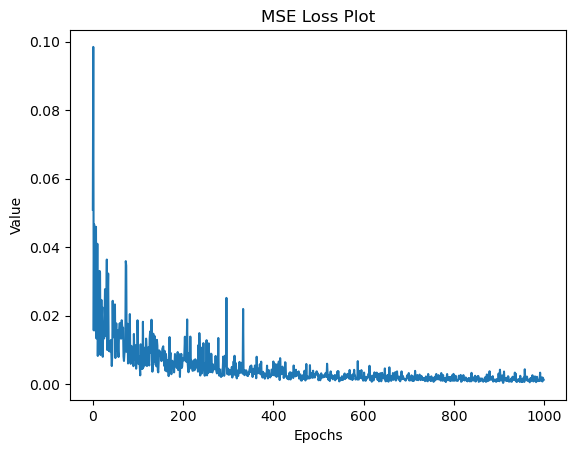

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(loss_list1)
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
training_data_hazy = []
training_data_gt = []

In [ ]:
for file in range(1, 1000):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  training_data_gt.append(np.array(img))

In [ ]:
for file in range(1, 1000):
  f = "{:d}".format(file) + '.png'
  path = os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  masks = mask_generator.generate(img)
  img_mask = gray_mask(masks)
  img = np.dstack((img, img_mask))
  training_data_hazy.append(np.array(img))

In [ ]:
X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])
X_hazy=torch.Tensor([training_data_hazy[i] for i in range(len(training_data_hazy))])

X_orig=X_orig/255
X_hazy_seg=X_hazy/255

/tmp/ipykernel_18418/4217046044.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])


In [ ]:
print('X_orig: ',X_orig.size())

X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_flat.shape)

X_orig:  torch.Size([999, 256, 256, 3])
X_orig_T:  torch.Size([999, 3, 256, 256])


In [ ]:
X_hazy_flat.shape

torch.Size([999, 4, 256, 256])

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(4,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

encoder = Encoder().cuda()

In [ ]:
decoder = Decoder().cuda()
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):

    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter1,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter1,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()

        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)

        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()
    losses.append(loss)

loss_list2 = [loss.cpu().detach().numpy() for loss in losses]

100%|█████████████████████████████████████| 1000/1000 [3:40:46<00:00, 13.25s/it]


In [ ]:
with open(r'loss_with_SAM', 'w') as fp:
    for item in loss_list2:
        fp.write("%s\n" % item)
    print('Done')

Done


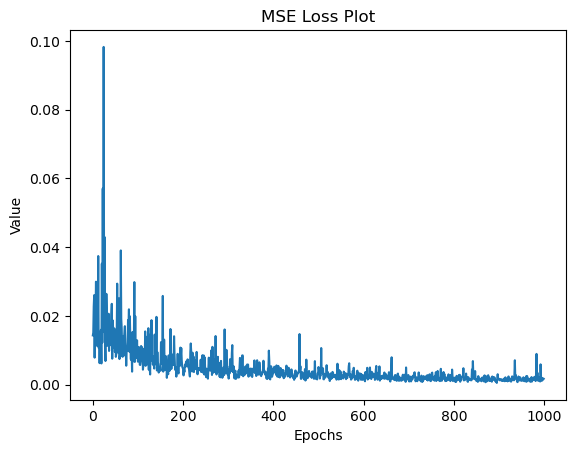

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(loss_list2)
plt.show()

In [ ]:
loss_list1 = []
with open(r'loss_without_SAM', 'r') as fp:
    for line in fp:
        x = line[:-1]
        loss_list1.append(x)

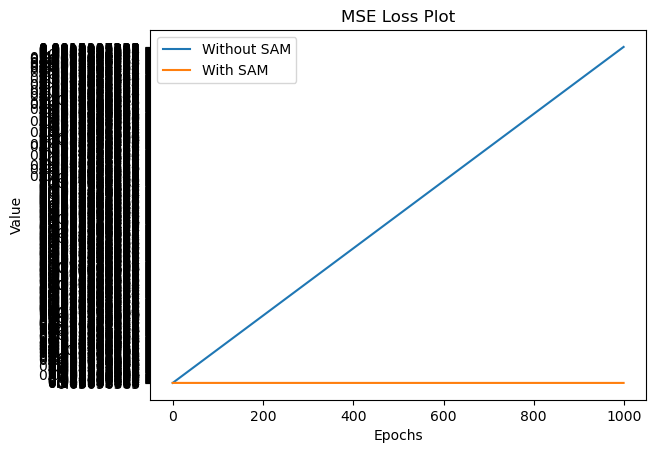

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(loss_list1, label="Without SAM")
plt.plot(loss_list2, label="With SAM")
plt.legend()
plt.show()

In [ ]:
loss_list2

[array(0.01434234, dtype=float32),
 array(0.01515307, dtype=float32),
 array(0.02272491, dtype=float32),
 array(0.02604623, dtype=float32),
 array(0.00786561, dtype=float32),
 array(0.01923288, dtype=float32),
 array(0.02019947, dtype=float32),
 array(0.02996495, dtype=float32),
 array(0.01492484, dtype=float32),
 array(0.01313586, dtype=float32),
 array(0.01120156, dtype=float32),
 array(0.01179899, dtype=float32),
 array(0.03743375, dtype=float32),
 array(0.0106907, dtype=float32),
 array(0.01072067, dtype=float32),
 array(0.00626714, dtype=float32),
 array(0.0106312, dtype=float32),
 array(0.01471665, dtype=float32),
 array(0.01596619, dtype=float32),
 array(0.00617996, dtype=float32),
 array(0.03521111, dtype=float32),
 array(0.01222134, dtype=float32),
 array(0.05707832, dtype=float32),
 array(0.01531968, dtype=float32),
 array(0.09827226, dtype=float32),
 array(0.02359277, dtype=float32),
 array(0.04297715, dtype=float32),
 array(0.01121692, dtype=float32),
 array(0.00688626, dty